In [1]:
#Importing Required modules
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


# 2.Define image properties:

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

# 3.Prepare dataset for training model:

In [3]:
filenames=os.listdir("./dogs-vs-cats/train/train")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

# 4. Create the neural net model:

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

# 5. Analyzing model:

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

# 6. Define callbacks and learning rate:

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

# 7. Manage data:

In [7]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [18]:
train_df.head()

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat


# 8. Training and validation data generator:

In [11]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dogs-vs-cats/train/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
# test_generator = train_datagen.flow_from_dataframe(train_df,
#                                                  "./dogs-vs-cats/test1/test1/",x_col='filename',y_col='category',
#                                                  target_size=Image_Size,
#                                                  class_mode='categorical',
#                                                  batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 0 classes.


C:\Users\Keerthi\.conda\envs\venv1\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 20000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# 9. Model Training:

In [12]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 1785s 1s/step - loss: 0.7473 - accuracy: 0.6358 - val_loss: 0.4967 - val_accuracy: 0.6983


C:\Users\Keerthi\.conda\envs\venv1\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/10
1333/1333 [==============================] - 1672s 1s/step - loss: 0.5566 - accuracy: 0.7204 - val_loss: 0.3127 - val_accuracy: 0.7386
Epoch 3/10
1333/1333 [==============================] - 2165s 2s/step - loss: 0.5025 - accuracy: 0.7594 - val_loss: 0.1348 - val_accuracy: 0.7936
Epoch 4/10
1333/1333 [==============================] - 2376s 2s/step - loss: 0.4639 - accuracy: 0.7877 - val_loss: 1.1778 - val_accuracy: 0.6514
Epoch 5/10
1333/1333 [==============================] - 14084s 11s/step - loss: 0.4387 - accuracy: 0.7995 - val_loss: 0.2537 - val_accuracy: 0.8473
Epoch 6/10
1333/1333 [==============================] - 1784s 1s/step - loss: 0.4191 - accuracy: 0.8115 - val_loss: 0.3253 - val_accuracy: 0.8213
Epoch 7/10
1333/1333 [==============================] - 1770s 1s/step - loss: 0.4013 - accuracy: 0.8223 - val_loss: 0.5129 - val_accuracy: 0.8289
Epoch 8/10
1333/1333 [==============================] - 1656s 1s/step - loss: 0.3842 - accuracy: 0.8311 - val_loss: 0.3838

# 10. Save the model:

In [15]:
model.save("model1_catsVSdogs_10epoch.h5")

# 11. Test data preparation:

In [24]:
test_filenames = os.listdir("./dogs-vs-cats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "./dogs-vs-cats/test1/test1/",x_col='filename',y_col=None,
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size
                                                  )

Found 12500 validated image filenames.


# 12. Make categorical prediction:

In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

# 13. Convert labels to categories:

In [26]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# 14. Visualize the prediction results:

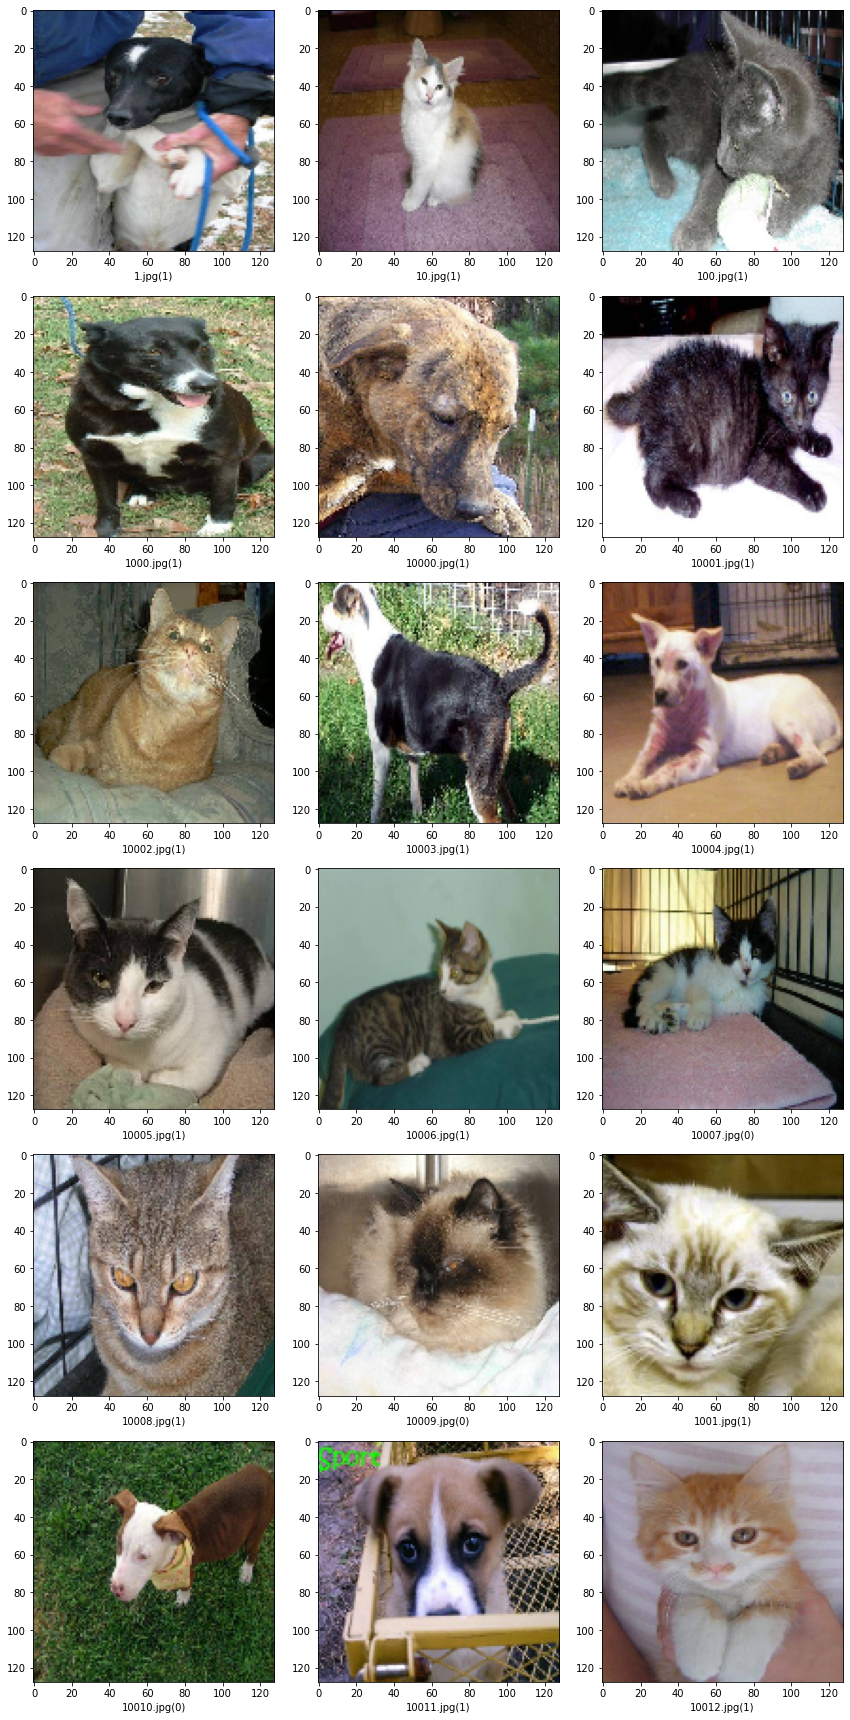

In [28]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dogs-vs-cats/test1/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# 15.Cats VS Dogs Classifier GUI:

In [29]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

from keras.models import load_model
model = load_model('model1_catsVSdogs_10epoch.h5')
#dictionary to label all traffic signs class.
classes = { 
    0:'its a cat',
    1:'its a dog',
 
}
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('CatsVSDogs Classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((128,128))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict_classes([image])[0]
    sign = classes[pred]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

its a dog
its a cat
its a dog
